In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# source: https://github.com/cjmcgill/characterizing_uncertainty_scripts/blob/main/figure_scripts/figure_8.py
def compute_auce(pred, unce, true, q=10):
    calibration_x = [0]
    calibration_y = [0]
    calibration_y_oracle = [0]
    auce = 0
    for i in range(q):
        upper = (i+1)*1/q
        ctr = 0
        for u,p,t in zip(unce,pred,true):
            s = np.sqrt(u)
            i = stats.norm.interval(confidence=upper, loc=p, scale=s) 
            if t>= i[0] and t <= i[1]:
                ctr+=1
        calibration_x.append(upper)
        calibration_y.append(ctr/len(unce))
        calibration_y_oracle.append(upper)
        auce += abs(ctr/len(unce) - upper) * 1/q
    return auce, calibration_x, calibration_y, calibration_y_oracle

def create_subplot_auce(system, true, pred, unce, xlabel=False, ylabel=False):
    target_name_dict = {"1syh score":"1syh score", "4lde score":"4lde score", "6y2f score":"6y2f score",
                        "singlet-triplet value":"singlet-triplet value", "oscillator strength":"oscillator strength", 
                        "abs_diff_vee":"absolute difference of \nvertical excitation  energy",
                        "activation_energy":"activation energy", "reaction_energy":"reaction energy"}
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(target_name_dict[system],fontsize=12)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)), fontsize=12)
    if xlabel:
        plt.xlabel("Estimated confidence", fontsize=14)
    if ylabel:
        plt.ylabel("Proportion correct", fontsize=14)
    print(system, auce)


## Plot all auce plots in 4 x 2 subplot

singlet-triplet value 0.02283499999999999
oscillator strength 0.077905
abs_diff_vee 0.026004999999999993
1syh score 0.04495999999999999
4lde score 0.034550000000000004
6y2f score 0.014765
activation_energy 0.0431768864047345
reaction_energy 0.08584990958408682


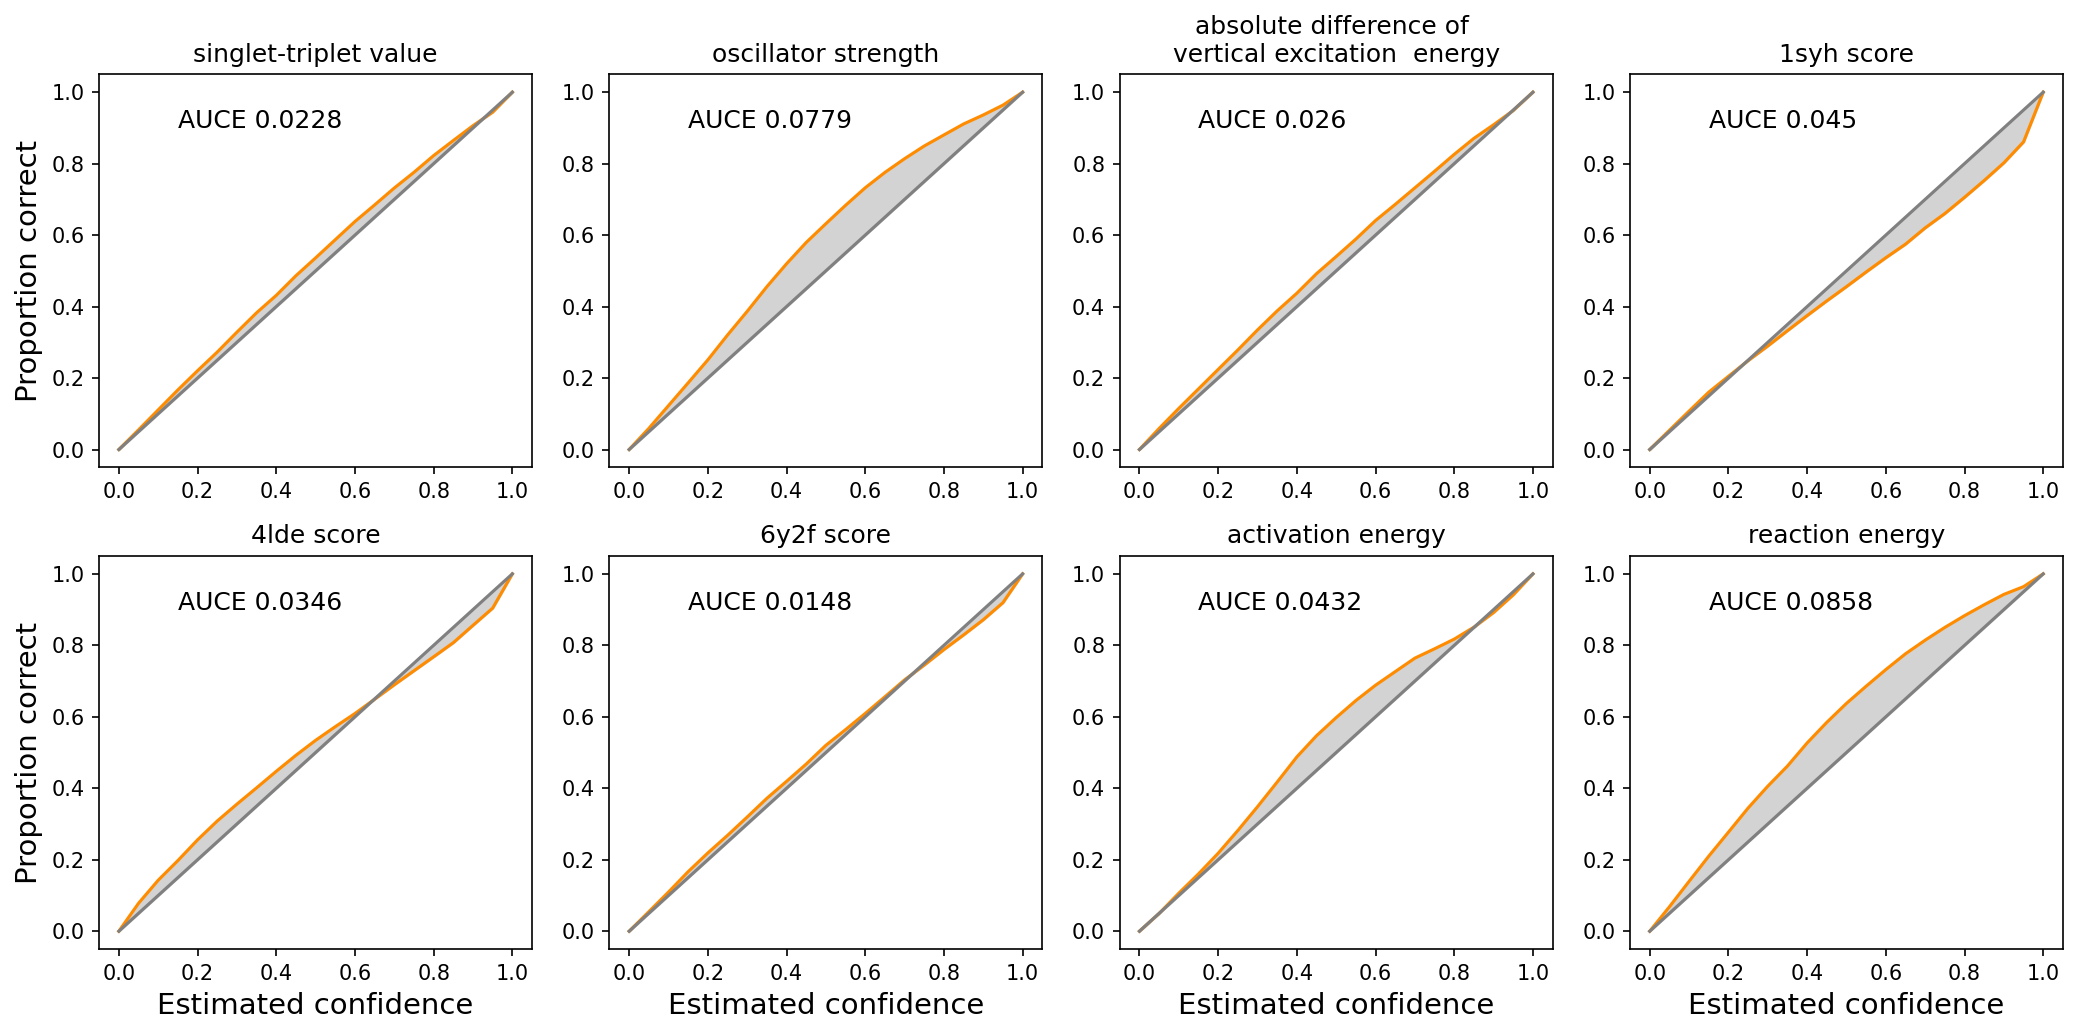

In [2]:
dataset_target = [("organic_emitter", "singlet-triplet value"), ("organic_emitter", "oscillator strength"), ("organic_emitter", "abs_diff_vee"),
                  ("docking", "1syh score"), ("docking", "4lde score"), ("docking", "6y2f score"),
                  ("reactivity", "activation_energy"), ("reactivity", "reaction_energy")]
model_dict = {"docking":"chemprop_unc/save_models/docking/evidential/fold_0",
              "organic_emitter":"chemprop_unc/save_models/organic_emitter/ensemble_mve/fold_0",
              "reactivity":"chemprop_unc/save_models/reactivity/evidential_final/fold_0"}
uncertainty_method_dict = {"docking": "evidential_total_uncal_var",
                           "organic_emitter": "mve_uncal_var",
                           "reactivity": "evidential_total_uncal_var"}

fig = plt.figure(figsize=(14,7), dpi=150)
for i, (dataset, target) in enumerate(dataset_target):
    xlabel = False
    ylabel = False

    j = i + 1
    x = i//4 + 1
    y = j%4
    if y == 0: 
        y = 4
    if x == 2:
        xlabel = True
    if y == 1:
        ylabel = True
    plt.subplot(int(str(2) + str(4) + str(j)))
    model_path = model_dict[dataset]
    uncertainty_method = uncertainty_method_dict[dataset]
    unc_name = target + "_" + uncertainty_method

    true_df = pd.read_csv(os.path.join(model_path, "test_full.csv"))
    pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
    n=10000
    if dataset == "reactivity":
        n = len(true_df)
    index = true_df.sample(n, random_state=0).index

    true = true_df[target].values[index]
    pred = pred_df[target].values[index]
    unce = pred_df[unc_name].values[index]
    create_subplot_auce(target, true, pred, unce, xlabel=xlabel, ylabel=ylabel)
else:
    plt.tight_layout()
    plt.savefig("figures/auce_plots/overall_auce.svg", format="svg")

## Organic emitter design

In [4]:
# mve version
n=10000
target_columns = ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]
target_path = "./chemprop_unc/save_models/organic_emitter/ensemble_mve/fold_0/test_unc.csv"
true_path = "./chemprop_unc/save_models/organic_emitter/ensemble_mve/fold_0/test_full.csv"
save_dir = "figures/auce_plots/oe_ensemble_mve_unc"
os.makedirs(save_dir, exist_ok=True)

true_df = pd.read_csv(true_path)
pred_df = pd.read_csv(target_path)
index = true_df.sample(n, random_state=0).index

singlet-triplet value 0.02283499999999999
oscillator strength 0.077905
abs_diff_vee 0.026004999999999993


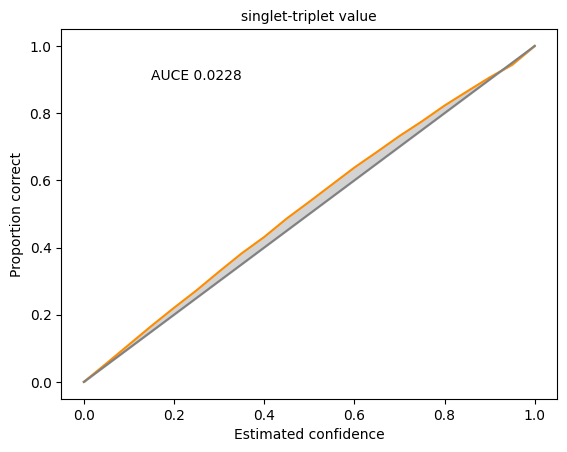

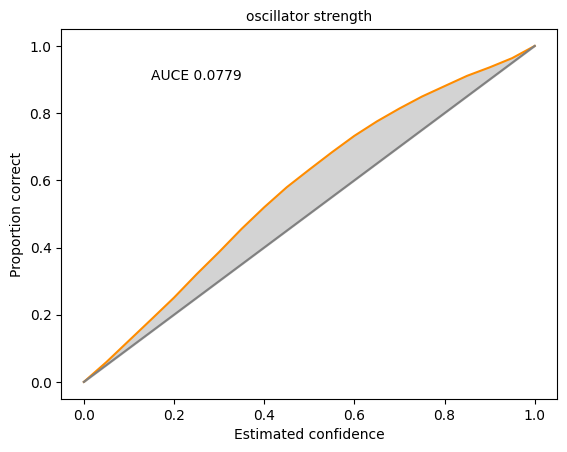

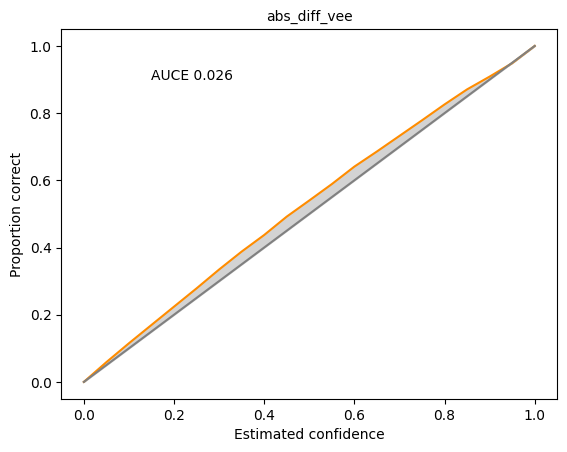

In [5]:
for system in target_columns:
    unc_name = system + "_mve_uncal_var"

    true = true_df[system].values[index]
    pred = pred_df[system].values[index]
    unce = pred_df[unc_name].values[index]

    plt.figure(dpi=100)
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(system,fontsize=10)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)))
    plt.xlabel("Estimated confidence")
    plt.ylabel("Proportion correct")
    print(system, auce)
    plt.savefig(os.path.join(save_dir, system+".svg"), format='svg')

# Docking

In [6]:
target_columns = ["1syh score", "4lde score", "6y2f score"]

target_path = "./chemprop_unc/save_models/docking/evidential/fold_0/test_unc.csv"
true_path = "./chemprop_unc/save_models/docking/evidential/fold_0/test_full.csv"
save_dir = "figures/auce_plots/docking_evidential_lambda_02"
os.makedirs(save_dir, exist_ok=True)

true_df = pd.read_csv(true_path)
pred_df = pd.read_csv(target_path)

n=10000
index = true_df.sample(n, random_state=0).index


1syh score 0.04495999999999999
4lde score 0.034550000000000004
6y2f score 0.014765


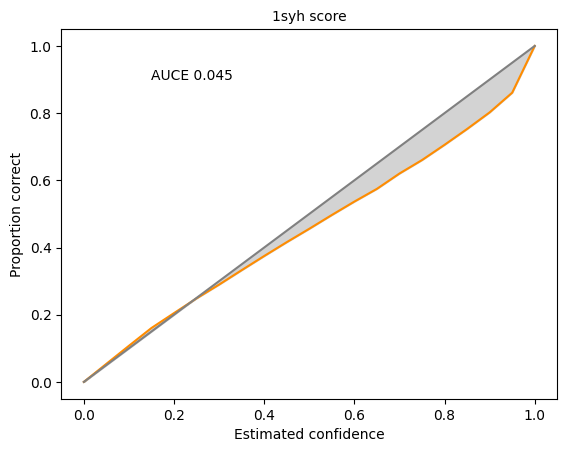

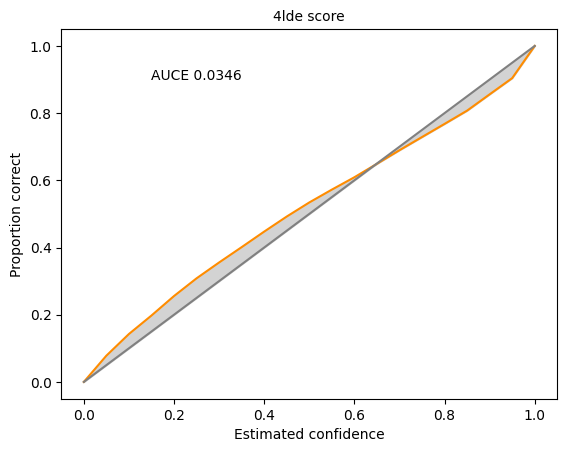

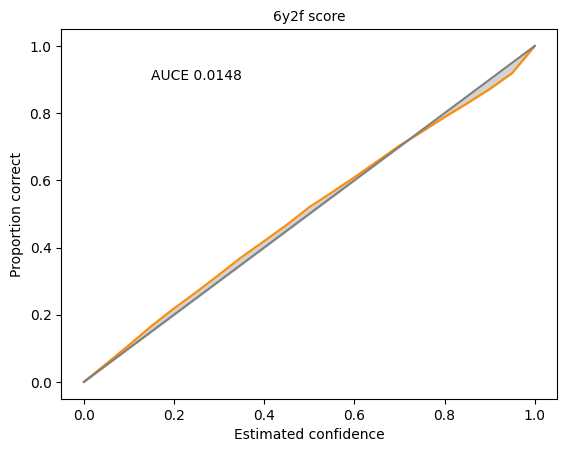

In [7]:
for system in target_columns:
    unc_name = system + "_evidential_total_uncal_var"

    true = true_df[system].values[index]
    pred = pred_df[system].values[index]
    unce = pred_df[unc_name].values[index]

    plt.figure(dpi=100)
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(system,fontsize=10)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)))
    plt.xlabel("Estimated confidence")
    plt.ylabel("Proportion correct")
    print(system, auce)
    plt.savefig(os.path.join(save_dir, system+".svg"), format='svg')

### Reactivity

In [8]:
target_columns = ["activation_energy", "reaction_energy"]
dataset = "reactivity"

target_path = "./chemprop_unc/save_models/reactivity/evidential_final/fold_0/test_unc.csv"
true_path = "./chemprop_unc/save_models/reactivity/evidential_final/fold_0/test_full.csv"
save_dir = "figures/auce_plots/reactivity_evidential_reg0001_drop040_total"
os.makedirs(save_dir, exist_ok=True)

true_df = pd.read_csv(true_path)
pred_df = pd.read_csv(target_path)

# n=10000
# index = true_df.sample(n, random_state=0).index


activation_energy 0.0431768864047345
reaction_energy 0.08584990958408682


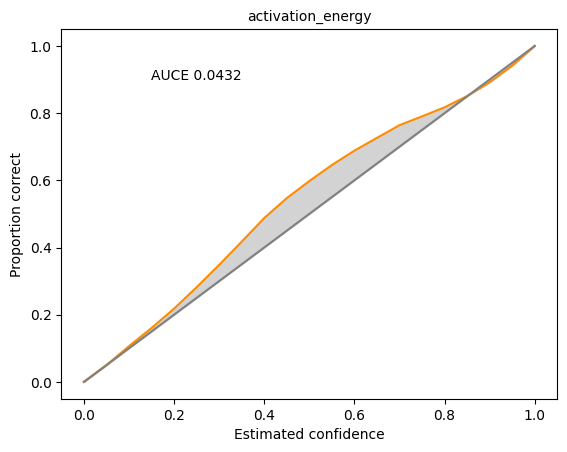

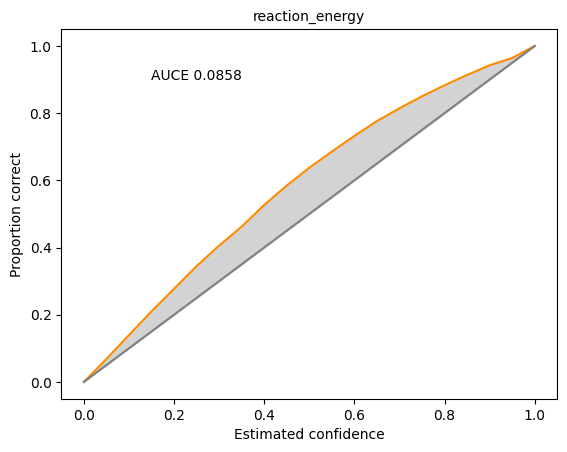

In [9]:
for system in target_columns:
    unc_name = system + "_evidential_total_uncal_var"

    true = true_df[system].values # [index]
    pred = pred_df[system].values # [index]
    unce = pred_df[unc_name].values # [index]

    plt.figure(dpi=100)
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(system,fontsize=10)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)))
    plt.xlabel("Estimated confidence")
    plt.ylabel("Proportion correct")
    print(system, auce)
    plt.savefig(os.path.join(save_dir, system+".svg"), format='svg')